identiBEAN is a dry bean indentifying tool

In [1]:
import math
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

#image segmentation
import cv2
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu

#image processing
from skimage.measure import regionprops

#model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.metrics import categorical_crossentropy

In [8]:
train_labels = []
train_samples = []

#importing data from arff file to numpy array
data = arff.loadarff(r"/home/Dry_Bean_Dataset.arff")
df = pd.DataFrame(data[0])
df = df.to_numpy()

#putting data into lists for samples and labels
for i in range(np.size(df,0)):
  if(df[i][16] == b'SEKER'):
    train_labels.append(0)
  elif(df[i][16] == b'BARBUNYA'):
    train_labels.append(1)
  elif(df[i][16] == b'BOMBAY'):
    train_labels.append(2)
  elif(df[i][16] == b'CALI'):
    train_labels.append(3)
  elif(df[i][16] == b'HOROZ'):
    train_labels.append(4)
  elif(df[i][16] == b'SIRA'):
    train_labels.append(5)
  elif(df[i][16] == b'DERMASON'):
    train_labels.append(6)

for i in range(np.size(df,0)):
  train_samples.append(df[i][[4,5,8,9,10,11]])

#list to numpy array
train_samples = np.asarray(train_samples).astype('float32')
train_labels = np.asarray(train_labels)

#converting labels to onehot values
train_labels = to_categorical(train_labels)

#shuffle labels and samples respectively
train_labels, train_samples = shuffle(train_labels, train_samples)

In [ ]:
#creating model
model = Sequential([
    Dense(units = 16, input_shape = (6,), activation = 'selu'),
    Dense(units = 16, activation = 'selu'),
    Dense(units = 7, activation = 'softmax')
])

model.summary()

#compile and fir the model with the training data
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_samples, y=train_labels, validation_split=0.1, epochs=500, verbose=2)

<function matplotlib.pyplot.show>

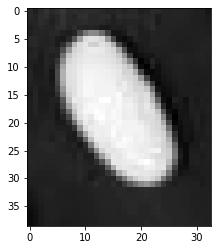

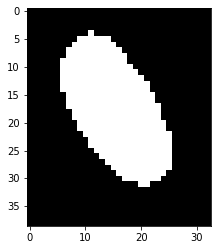

In [5]:
#IMAGE SEGMENTATION
img = cv2.imread('/home/beanHoroz.JPG', 0)

#starting image
plt.figure("og image")
plt.imshow(img, cmap="gray")

#bluring image
blur = cv2.GaussianBlur(img,(5,5),0)
#thresholding
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
image = thresh

#flooding around bean
imageCopy = image.copy()
h,w = image.shape[:2]
mask = np.zeros((h + 2, w + 2), np.uint8)
cv2.floodFill(image, mask, (0,0), 255)

#inverting flooded image
iminv = cv2.bitwise_not(image)

#combining original image with inverted flooded image
image = imageCopy | iminv

#final image
plt.figure("image")
plt.imshow(image, cmap="gray")

plt.show

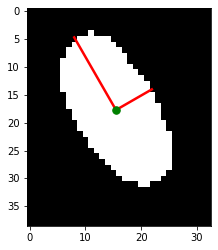

aspect ratio: 2.0256240273763884
eccentricity: 0.8696464603303793
extent: 0.6232142857142857
solidity: 0.9587912087912088
roundness: 0.8043491676505778
compactness: 0.7018520034802668


In [6]:
#IMAGE PROCESSING
regions = regionprops(image)

plt.imshow(image, cmap="gray")

#displaying axis on bean
y0, x0 = regions[0].centroid
orientation = regions[0].orientation
x1 = x0 + math.cos(orientation) * 0.5 * regions[0].minor_axis_length
y1 = y0 - math.sin(orientation) * 0.5 * regions[0].minor_axis_length
x2 = x0 - math.sin(orientation) * 0.5 * regions[0].major_axis_length
y2 = y0 - math.cos(orientation) * 0.5 * regions[0].major_axis_length

plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
plt.plot(x0, y0, '.g', markersize=15)

plt.show()

#calculating aspect ratio
aspect_ratio = regions[0].major_axis_length/regions[0].minor_axis_length

eccentricity = regions[0].eccentricity

solidity = regions[0].solidity

extent = regions[0].extent

#calculating roundness
area = regions[0].area
perimeter = regions[0].perimeter
roundness = (4 * math.pi * area) / (perimeter*perimeter) 

#calculating compactness
Ed = regions[0].equivalent_diameter
L = regions[0].major_axis_length
compactness = Ed/L

print("aspect ratio:", aspect_ratio)
print("eccentricity:", eccentricity)
print("extent:", extent)
print("solidity:", solidity)
print("roundness:", roundness)
print("compactness:", compactness)

#putting data into a numpy array to be used in prediction
test_data = np.array([[aspect_ratio, eccentricity, extent, solidity, roundness, compactness]])

In [7]:
#PREDICTION
prediction = model.predict(test_data)
bean = np.array(np.argmax(prediction, axis = 1))

classification = ['Seker', 'Barbunya', 'Bombay', 'Cali', 'Horoz', 'Sira', 'Dermason']
print("Model predicted bean as", classification[bean[0]], "with", ' '.join(map(str, 100*prediction[0, np.argmax(prediction, axis = 1)])), "% confidence")

Model predicted bean as Horoz with 98.520004 % confidence
